# Best K selection and why different K for every classifier on each database ? 

In [1]:
import numpy as np
from scipy.stats import mode


# K Nearest Neighbors Classification
class KNN:

    def __init__(self, k):
        self.n = None
        self.m = None
        self.y_train = None
        self.x_train = None
        self.k = k

    # function to store training set
    def fit(self, x_train, y_train):
        self.x_train = x_train
        self.y_train = y_train

        # no_of_training_examples, no_of_features
        self.m, self.n = self.x_train.shape

    # function for prediction
    def predict(self, x_test):
        # no_of_test_examples, no_of_features
        m_test, self.n = x_test.shape

        # initialize Y_predict
        y_predict = np.zeros(m_test)

        for i in range(m_test):
            # find the k nearest neighbors from current test example
            neighbors = np.zeros(self.k)
            neighbors = self.find_neighbors(x_test[i])

            # most frequent class in k neighbors
            y_predict[i] = mode(neighbors)[0][0]

        return y_predict

    # function to find the k nearest neighbors to current test example
    def find_neighbors(self, x):
        # calculate all the euclidean distances between current test example x and training set X_train
        euclidean_distances = np.zeros(self.m)
        x = np.reshape(x, (1, self.n))

        # create x for broadcasting with X_train
        x = np.repeat(x, repeats=self.m, axis=0)

        # (x - y)^2 = x^2 + y^2 - 2 * x * y
        euclidean_distances = np.sum((np.square(x) + np.square(self.x_train) - 2 * self.x_train * x), axis=1)

        # sort y_train according to euclidean_distance_array and store into y_train_sorted
        ids = euclidean_distances.argsort()

        return self.y_train[ids[:self.k]]

In [2]:
# from knn import KNN
from scipy.io import loadmat
from scipy.stats import zscore
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import balanced_accuracy_score


def best_k(file):
    # load database
    data = loadmat(file)
    x = data['X']
    y = data['Y']

    # standardise
    x = zscore(x)

    best_n = 0
    best_score = 0
    
    report_K = []
    report_BA = []
    

    # select best K
    for i in range(1, 30, 2):

        # initialize leave one out cross validation object
        cv = LeaveOneOut()

        # enumerate splits
        y_true, y_predict = list(), list()

        for train_ix, test_ix in cv.split(x):
            # split data
            x_train, x_test = x[train_ix, :], x[test_ix, :]
            y_train, y_test = y[train_ix], y[test_ix]

            # fit model
            model = KNN(k=i)
            model.fit(x_train, y_train)

            # evaluate model
            yhat = model.predict(x_test)

            # store
            y_true.append(y_test[0])
            y_predict.append(yhat[0])

        # calculate accuracy
        score = balanced_accuracy_score(y_true, y_predict)
        
        report_K.append(i)
        report_BA.append(score)

        # select best score and best K
        if score > best_score:
            best_score = score
            best_n = i

    return best_n, report_K, report_BA 

In [3]:
# search best K for that dataset
nk, report_K, report_BA = best_k('climate.mat')

In [4]:
# search best K for that dataset
nkb, report_Kb, report_BAb = best_k('blood.mat')

In [5]:
# search best K for that dataset
nkc, report_Kc, report_BAc = best_k('Cryotherapy.mat')

In [6]:
import matplotlib.pyplot as plt

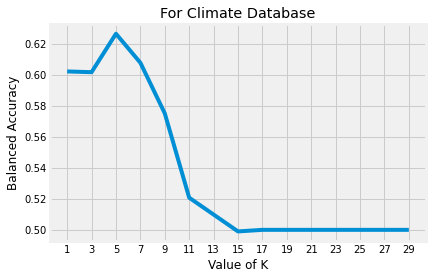

In [7]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 30, 2), report_BA)
plt.xticks(range(1, 30,2))
plt.xlabel("Value of K")
plt.ylabel("Balanced Accuracy")
plt.title("For Climate Database")
plt.show()

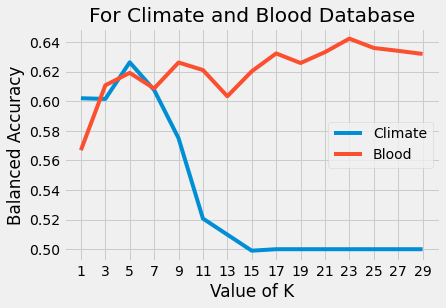

In [8]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 30, 2), report_BA, label = "Climate")
plt.plot(range(1, 30, 2), report_BAb, label = "Blood")
# plt.plot(range(1, 30, 2), report_BAc, label = "Cryotherapy")
plt.legend(loc="center right")
plt.xticks(range(1, 30,2))
plt.xlabel("Value of K")
plt.ylabel("Balanced Accuracy")
plt.title("For Climate and Blood Database")
plt.show()

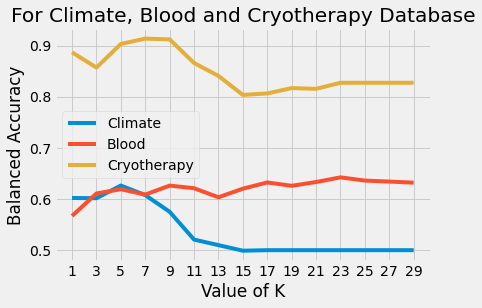

In [9]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 30, 2), report_BA, label = "Climate")
plt.plot(range(1, 30, 2), report_BAb, label = "Blood")
plt.plot(range(1, 30, 2), report_BAc, label = "Cryotherapy")
plt.legend(loc="center left")
plt.xticks(range(1, 30,2))
plt.xlabel("Value of K")
plt.ylabel("Balanced Accuracy")
plt.title("For Climate, Blood and Cryotherapy Database")
plt.show()

# Why threshold selection for Logistic Regression?

In [10]:
import numpy as np


def threshold_selection(z, y):
    # total number of examples
    n = np.size(z)

    # reshape y, z into 1 D
    y = np.reshape(y, n)
    z = np.reshape(z, n)

    # define set of unique values with all possible points
    threshold = np.unique(z)

    # add all borders
    threshold = (threshold[1:] + threshold[:-1]) / 2

    # selecting threshold with best error
    best_error = n
    best_threshold = 0
    
    
    ba = []
    thres = []

    for t in threshold:

        y_hat = np.where(z > t, 1, 0)
        error = sum(y_hat != y)

        if error < best_error:
            best_error = error
            best_threshold = t
            best_ac = balanced_accuracy_score(y_hat, y)
        
        thres.append(best_threshold)
        ba.append(best_ac)
        

    return best_threshold, thres, ba

In [11]:
# hypothetical function h(x)
def predict_sklearn(x, w, b):
    z = 1 / (1 + np.exp(- (x.dot(w.T) + b)))
    return z

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [34]:
# load database
data = loadmat("climate.mat")
x = data['X']
y = data['Y']

# standardise
x = zscore(x)


x_train, x_test, y_train, y_test = train_test_split(x, y)

# without dimensionality reduction
sk1 = LogisticRegression()
sk1.fit(x_train, y_train)
w1, b1 = sk1.coef_, sk1.intercept_
# predict on training set
y_train_predict = predict_sklearn(x_train, w1, b1)
# select optimal threshold on training dataset
threshold, thres, ba = threshold_selection(y_train_predict, y_train)


# # predict on test set
# y_test_predict = predict_sklearn(x_test, w1, b1)
# y_test_predict = np.where(y_test_predict > threshold, 1, 0)
# acc = balanced_accuracy_score(y_test, y_test_predict)
# print(acc)

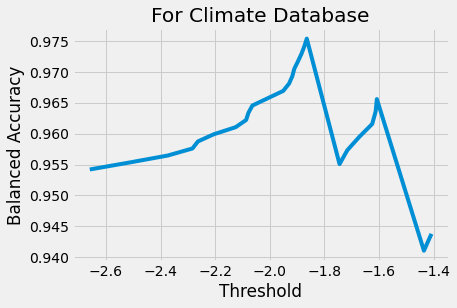

In [35]:
plt.style.use("fivethirtyeight")
plt.plot(thres, ba)
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.title("For Climate Database")
plt.show()

In [15]:
# load database
data = loadmat("breastCancer.mat")
x = data['X']
y = data['Y']

# standardise
x = zscore(x)


x_train, x_test, y_train, y_test = train_test_split(x, y)

# without dimensionality reduction
sk1 = LogisticRegression()
sk1.fit(x_train, y_train)
w1, b1 = sk1.coef_, sk1.intercept_
# predict on training set
y_train_predict = predict_sklearn(x_train, w1, b1)
# select optimal threshold on training dataset
threshold, thresb, baBC = threshold_selection(y_train_predict, y_train)


# # predict on test set
# y_test_predict = predict_sklearn(x_test, w1, b1)
# y_test_predict = np.where(y_test_predict > threshold, 1, 0)
# acc = balanced_accuracy_score(y_test, y_test_predict)
# print(acc)

/home/mb856/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
# load database
data = loadmat("blood.mat")
x = data['X']
y = data['Y']

# standardise
x = zscore(x)


x_train, x_test, y_train, y_test = train_test_split(x, y)

# without dimensionality reduction
sk1 = LogisticRegression()
sk1.fit(x_train, y_train)
w1, b1 = sk1.coef_, sk1.intercept_
# predict on training set
y_train_predict = predict_sklearn(x_train, w1, b1)
# select optimal threshold on training dataset
threshold, thresbl, baBL = threshold_selection(y_train_predict, y_train)


# # predict on test set
# y_test_predict = predict_sklearn(x_test, w1, b1)
# y_test_predict = np.where(y_test_predict > threshold, 1, 0)
# acc = balanced_accuracy_score(y_test, y_test_predict)
# print(acc)

/home/mb856/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


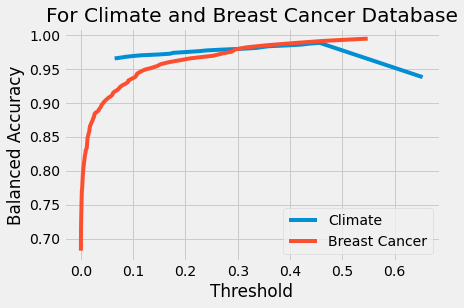

In [17]:
plt.style.use("fivethirtyeight")
plt.plot(thres, ba, label = "Climate")
plt.plot(thresb, baBC, label = "Breast Cancer")
# plt.plot(thresbl, erbl, label = "Blood")
plt.legend(loc="lower right")
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.title("For Climate and Breast Cancer Database")
plt.show()

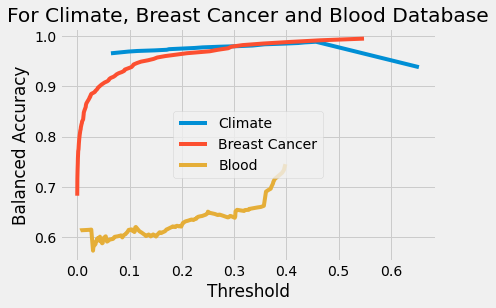

In [19]:
plt.style.use("fivethirtyeight")
plt.plot(thres, ba, label = "Climate")
plt.plot(thresb, baBC, label = "Breast Cancer")
plt.plot(thresbl, baBL, label = "Blood")
plt.legend(loc="center")
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.title("For Climate, Breast Cancer and Blood Database")
plt.show()

In [21]:
from sklearn.model_selection import StratifiedKFold

In [26]:
# load database
data = loadmat("climate.mat")
x = data['X']
y = data['Y']

# standardise
x = zscore(x)



# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
ba_fold = []
thre_fold = []
  
for train_index, test_index in skf.split(x, y):
    x_train_fold, x_test_fold = x[train_index], x[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    sk1 = LogisticRegression()
    sk1.fit(x_train_fold, y_train_fold)
    w1, b1 = sk1.coef_, sk1.intercept_
    
    # predict on training set
    y_train_predict = predict_sklearn(x_train_fold, w1, b1)
    # select optimal threshold on training dataset
    best_threshold, thres, ba = threshold_selection(y_train_predict, y_train_fold)
    
    # predict on test set
    y_test_predict = predict_sklearn(x_test_fold, w1, b1)
    y_test_predict = np.where(y_test_predict > best_threshold, 1, 0)
    ba_fold.append(balanced_accuracy_score(y_test_fold, y_test_predict))
    thre_fold.append(best_threshold)

/home/mb856/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mb856/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mb856/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/mb856/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please chan

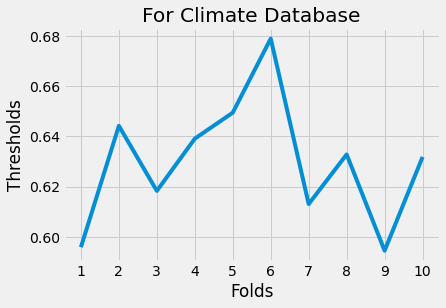

In [27]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11, 1), thre_fold)
plt.xticks(range(1, 11,1))
plt.xlabel("Folds")
plt.ylabel("Thresholds")
plt.title("For Climate Database")
plt.show()

# Threshold for Fisher Discrimimant 

In [39]:
import numpy as np


class Fisher:

    def __init__(self):
        self.direction = None

    def fit(self, x, y):
        # samples segregation based on class
        x_class1 = x[np.where(y == 1)[0], :]
        x_class0 = x[np.where(y == 0)[0], :]

        # calculate mean
        mean_x_class1 = x_class1.mean(axis=0)
        mean_x_class0 = x_class0.mean(axis=0)

        # calculate covariance matrices
        cov_x_class1 = np.cov(x_class1, rowvar=False)
        cov_x_class0 = np.cov(x_class0, rowvar=False)

        matrix = cov_x_class1 + cov_x_class0

        if mean_x_class1.shape[0] == 1:
            matrix = np.asarray([[matrix]])

        matrix = matrix + 0.001 * max(abs(np.diag(matrix))) * np.eye(np.size(mean_x_class1))

        # calculate fisher directions
        diff = np.array(mean_x_class1 - mean_x_class0)
        self.direction = np.linalg.inv(matrix).dot(diff)

        # normalize fisher directions
        self.direction = self.direction / np.sqrt(np.sum(np.square(self.direction)))

    # hypothetical function  h(x)
    def predict(self, x):
        z = np.dot(x, self.direction)
        return z

In [48]:
# load database
data = loadmat('climate.mat')
x = data['X']
y = data['Y']

# standardise
x = zscore(x)


x_train, x_test, y_train, y_test = train_test_split(x, y)

# without dimensionality reduction
sk1 = Fisher()
sk1.fit(x_train, y_train)
# predict on training set
y_train_predict = sk1.predict(x_train)
# select optimal threshold on training dataset
threshold, thres, ba = threshold_selection(y_train_predict, y_train)

# # predict on test set
# y_test_predict = predict_sklearn(x_test, w1, b1)
# y_test_predict = np.where(y_test_predict > threshold, 1, 0)
# acc = balanced_accuracy_score(y_test, y_test_predict)
# print(acc)

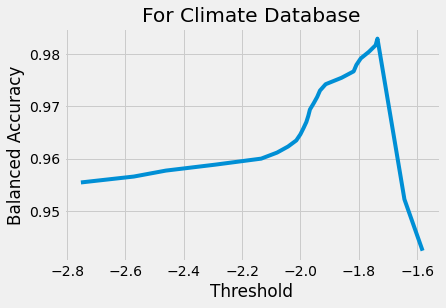

In [49]:
plt.style.use("fivethirtyeight")
plt.plot(thres, ba)
# plt.xticks(range(1, 30,2))
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.title("For Climate Database")
plt.show()

In [51]:
# load database
data = loadmat("breastCancer.mat")
x = data['X']
y = data['Y']

# standardise
x = zscore(x)


x_train, x_test, y_train, y_test = train_test_split(x, y)

# without dimensionality reduction
sk1 = Fisher()
sk1.fit(x_train, y_train)
# w1, b1 = sk1.coef_, sk1.intercept_
# predict on training set
y_train_predict = sk1.predict(x_train)
# select optimal threshold on training dataset
threshold, thresb, baBC = threshold_selection(y_train_predict, y_train)


# # predict on test set
# y_test_predict = predict_sklearn(x_test, w1, b1)
# y_test_predict = np.where(y_test_predict > threshold, 1, 0)
# acc = balanced_accuracy_score(y_test, y_test_predict)
# print(acc)

In [52]:
# load database
data = loadmat("blood.mat")
x = data['X']
y = data['Y']

# standardise
x = zscore(x)


x_train, x_test, y_train, y_test = train_test_split(x, y)

# without dimensionality reduction
sk1 = Fisher()
sk1.fit(x_train, y_train)
# w1, b1 = sk1.coef_, sk1.intercept_
# predict on training set
y_train_predict = sk1.predict(x_train)
# select optimal threshold on training dataset
threshold, thresb, baBC = threshold_selection(y_train_predict, y_train)


# # predict on test set
# y_test_predict = predict_sklearn(x_test, w1, b1)
# y_test_predict = np.where(y_test_predict > threshold, 1, 0)
# acc = balanced_accuracy_score(y_test, y_test_predict)
# print(acc)

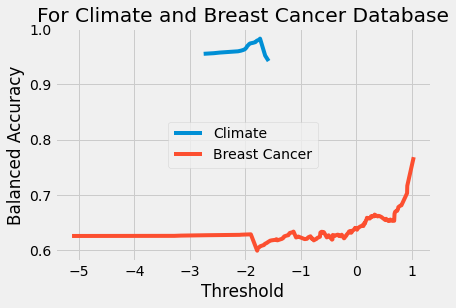

In [57]:
plt.style.use("fivethirtyeight")
plt.plot(thres, ba, label = "Climate")
plt.plot(thresb, baBC, label = "Breast Cancer")
# plt.plot(thresbl, erbl, label = "Blood")
plt.legend(loc="center")
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.title("For Climate and Breast Cancer Database")
plt.show()

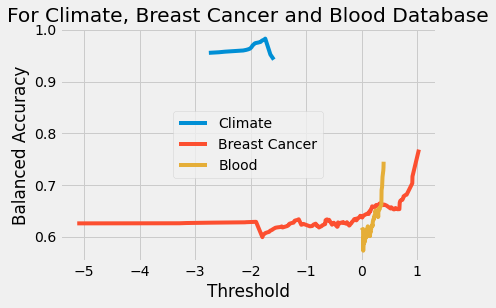

In [58]:
plt.style.use("fivethirtyeight")
plt.plot(thres, ba, label = "Climate")
plt.plot(thresb, baBC, label = "Breast Cancer")
plt.plot(thresbl, baBL, label = "Blood")
plt.legend(loc="center")
plt.xlabel("Threshold")
plt.ylabel("Balanced Accuracy")
plt.title("For Climate, Breast Cancer and Blood Database")
plt.show()

In [60]:
# load database
data = loadmat("climate.mat")
x = data['X']
y = data['Y']

# standardise
x = zscore(x)



# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
ba_fold = []
thre_fold = []
  
for train_index, test_index in skf.split(x, y):
    x_train_fold, x_test_fold = x[train_index], x[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    sk1 = Fisher()
    sk1.fit(x_train_fold, y_train_fold)
    # w1, b1 = sk1.coef_, sk1.intercept_
    
    # predict on training set
    y_train_predict = sk1.predict(x_train_fold)
    # select optimal threshold on training dataset
    best_threshold, thres, ba = threshold_selection(y_train_predict, y_train_fold)
    
    # predict on test set
    y_test_predict = sk1.predict(x_test_fold)
    y_test_predict = np.where(y_test_predict > best_threshold, 1, 0)
    ba_fold.append(balanced_accuracy_score(y_test_fold, y_test_predict))
    thre_fold.append(best_threshold)

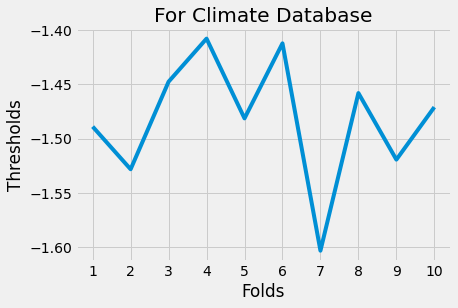

In [61]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11, 1), thre_fold)
plt.xticks(range(1, 11,1))
plt.xlabel("Folds")
plt.ylabel("Thresholds")
plt.title("For Climate Database")
plt.show()